In [15]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import pandas as pd
from torchsummary import summary
import time
import copy
import random
from glob import glob


from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(device)

cuda:1


In [4]:
seed = 777

def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
make_reproducible(seed)

In [20]:
train_data_paths = glob("./0/frame/*")
test_data_paths = glob("./0/frame/*")

In [22]:
train_label = np.load("./light_direction.npy", allow_pickle = True)
df = pd.DataFrame(train_label)
df.columns=['X','Y','Z']
df.insert(0, 'fname',train_data_paths)
df.head()

,fname,X,Y,Z
0,./0/frame/0001.png,0.000000,1.000000,0.000000
1,./0/frame/0002.png,0.012476,0.999877,-0.009493
2,./0/frame/0003.png,0.024970,0.999508,-0.019000
3,./0/frame/0004.png,0.037471,0.998891,-0.028512
4,./0/frame/0005.png,0.049971,0.998027,-0.038024


In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.metadata.iloc[idx,-3:]
        label = np.array([label])
        label = label.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [230]:
ratio = 0.2

train, valid = train_test_split(df, test_size = ratio, random_state = seed)
print("train : ", len(train))
print("valid : ", len(valid))

train :  160
valid :  40


In [231]:
im_size = 224
train_dataset = CustomDataset(train,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

test_dataset = CustomDataset(valid,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [232]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size, 
                                             shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


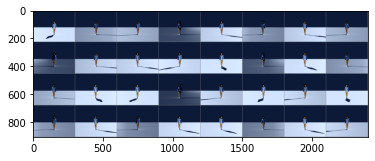

tensor([[ 0.7738, -0.2335, -0.5888],
        [ 0.2578,  0.9461, -0.1961],
        [ 0.3275, -0.9114, -0.2492],
        [ 0.0625,  0.9969, -0.0475],
        [ 0.6052,  0.6494, -0.4605],
        [ 0.2100,  0.9646, -0.1598],
        [ 0.5627, -0.7071, -0.4282],
        [ 0.2930,  0.9298, -0.2229],
        [ 0.0625, -0.9969, -0.0475],
        [ 0.4678,  0.8090, -0.3559],
        [ 0.6052, -0.6494, -0.4605],
        [ 0.6652, -0.5490, -0.5061],
        [ 0.7895,  0.1254, -0.6008],
        [ 0.0874,  0.9940, -0.0665],
        [ 0.7488, -0.3387, -0.5697],
        [ 0.2459,  0.9511, -0.1871],
        [ 0.3388, -0.9048, -0.2578],
        [ 0.7817, -0.1874, -0.5948],
        [ 0.7738,  0.2335, -0.5888],
        [ 0.0375,  0.9989, -0.0285],
        [ 0.4877,  0.7902, -0.3711],
        [ 0.7860, -0.1564, -0.5981],
        [ 0.4975, -0.7805, -0.3786],
        [ 0.7942, -0.0628, -0.6044],
        [ 0.2100, -0.9646, -0.1598],
        [ 0.6288, -0.6129, -0.4785],
        [ 0.1736, -0.9759, -0.1321],
 

In [233]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)

images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(features)

In [235]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [293]:
class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='arcface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

In [338]:
#from loss_functions import AngularPenaltySMLoss
num_epochs = 50
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
#in_features = 512
#out_features = 3 # Number of classes
#loss_func = AngularPenaltySMLoss(in_features, out_features, loss_type='sphereface') # loss_type in ['arcface', 'sphereface', 'cosface']
opt = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [339]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
#num_ftrs = model._fc.in_features # fc의 입력 노드 수를 산출한다. 1000개
#model._fc = nn.Linear(num_ftrs, 2) # fc를 nn.Linear(num_ftrs, 1)로 대체한다.

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [341]:
def train(model, train_loader, optimizer):#, logger):
    model.train()
#    for epoch in range(num_epochs):
    running_loss = 0.0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        criterion = nn.CosineSimilarity() 
        loss = torch.mean(torch.abs(criterion(gt,outputs)))
        loss = 1 - loss
        
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print('current batch: %d / %d'%(n, len(train_loader)))

    cost = running_loss / len(train_loader)
    train_loss_list.append(cost)
    
    #logger.info('train loss: %.4f, train acc: %.4f' %(cost, acc))

    print('train loss: %.4f' %(cost))

In [342]:
def test(model, test_loader, opt, ploting=False):#, logger):
    result = []
    model.eval()
    running_loss = 0.0
    run_cnt = 0
    
    with torch.no_grad():
        for data in test_loader:
            inputs, gt = data
            
            inputs, gt = inputs.to(device), gt.to(device)

            outputs = model(inputs)
            

            #loss = loss_func(outputs, gt.double()).float()
            criterion = nn.CosineSimilarity() 
            loss = torch.mean(torch.abs(criterion(gt,outputs)))
            loss = 1 - loss

            running_loss += loss.item()
            run_cnt += len(gt)
            result = result + outputs.tolist()
            
            if ploting == True:
                plt.scatter(gt.detach().cpu().numpy()[:,0], gt.detach().cpu().numpy()[:,1], c='r', label='real')
                plt.scatter(outputs.detach().cpu().numpy()[:,0], outputs.detach().cpu().numpy()[:,1], c='b', label='pred')
                

        cost = running_loss / len(test_loader)
        
        test_loss_list.append(cost)
        #logger.info('test loss: %.4f, test acc : %.4f' %(cost, acc))
        
        print('test loss: %.4f' %(cost))
        
        if ploting == True:
            plt.legend()
            plt.show()
        
        return result

==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
train loss: 0.5275
-------------------- TEST --------------------
test loss: 0.6831


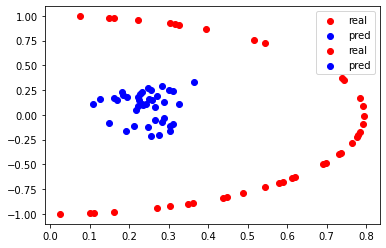

==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
train loss: 0.4941
-------------------- TEST --------------------
test loss: 0.6946


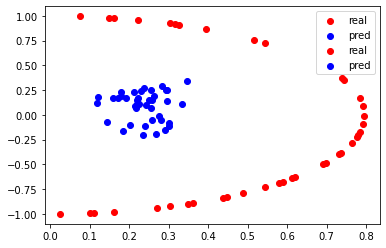

==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
train loss: 0.5515
-------------------- TEST --------------------
test loss: 0.6969


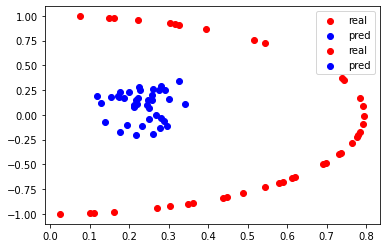

==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
train loss: 0.5549
-------------------- TEST --------------------
test loss: 0.6940


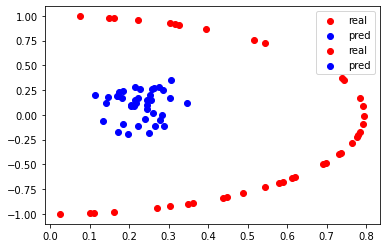

==================== EPOCH :  4 ====================
-------------------- TRAIN --------------------
train loss: 0.5634
-------------------- TEST --------------------
test loss: 0.6911


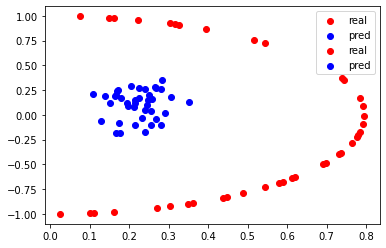

==================== EPOCH :  5 ====================
-------------------- TRAIN --------------------
train loss: 0.5387
-------------------- TEST --------------------
test loss: 0.6871


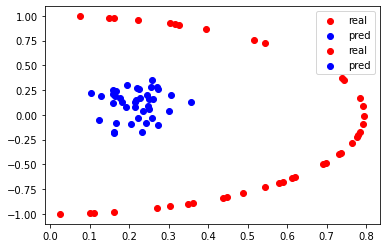

==================== EPOCH :  6 ====================
-------------------- TRAIN --------------------
train loss: 0.5488
-------------------- TEST --------------------
test loss: 0.6801


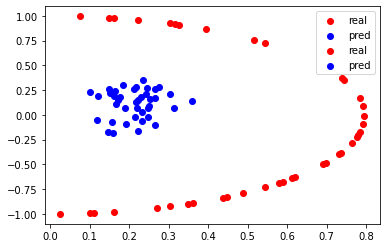

==================== EPOCH :  7 ====================
-------------------- TRAIN --------------------
train loss: 0.5648
-------------------- TEST --------------------
test loss: 0.6707


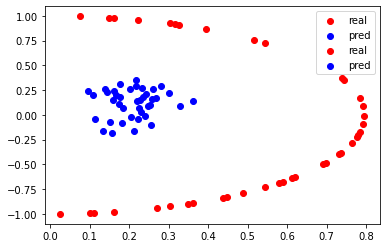

==================== EPOCH :  8 ====================
-------------------- TRAIN --------------------
train loss: 0.5576
-------------------- TEST --------------------
test loss: 0.6614


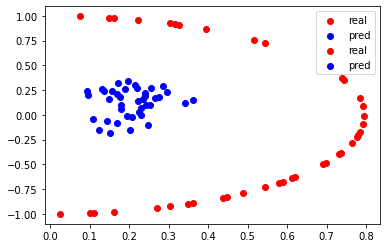

==================== EPOCH :  9 ====================
-------------------- TRAIN --------------------
train loss: 0.5412
-------------------- TEST --------------------
test loss: 0.6527


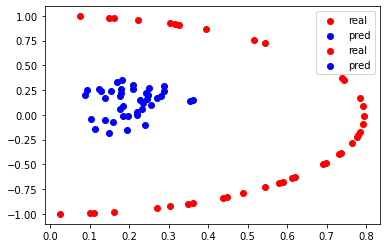

==================== EPOCH :  10 ====================
-------------------- TRAIN --------------------
train loss: 0.5288
-------------------- TEST --------------------
test loss: 0.6410


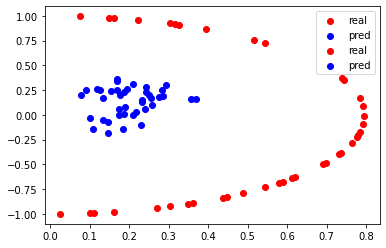

==================== EPOCH :  11 ====================
-------------------- TRAIN --------------------
train loss: 0.5664
-------------------- TEST --------------------
test loss: 0.6321


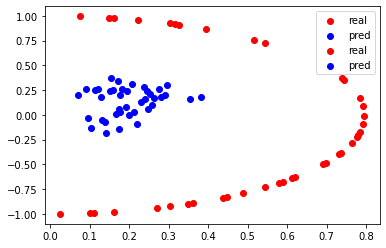

==================== EPOCH :  12 ====================
-------------------- TRAIN --------------------
train loss: 0.5725
-------------------- TEST --------------------
test loss: 0.6242


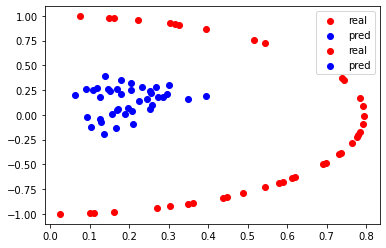

==================== EPOCH :  13 ====================
-------------------- TRAIN --------------------
train loss: 0.5395
-------------------- TEST --------------------
test loss: 0.6186


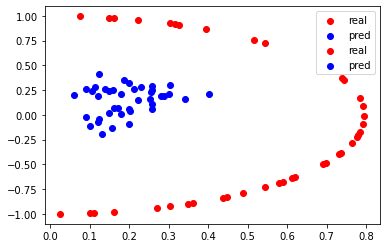

==================== EPOCH :  14 ====================
-------------------- TRAIN --------------------
train loss: 0.5538
-------------------- TEST --------------------
test loss: 0.6133


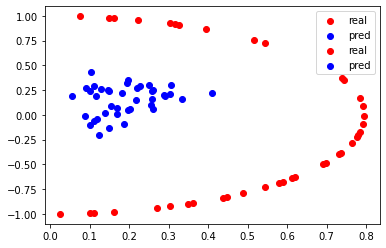

==================== EPOCH :  15 ====================
-------------------- TRAIN --------------------
train loss: 0.5220
-------------------- TEST --------------------
test loss: 0.6122


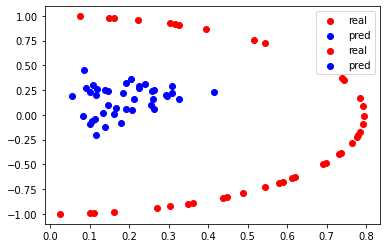

==================== EPOCH :  16 ====================
-------------------- TRAIN --------------------
train loss: 0.5701
-------------------- TEST --------------------
test loss: 0.6058


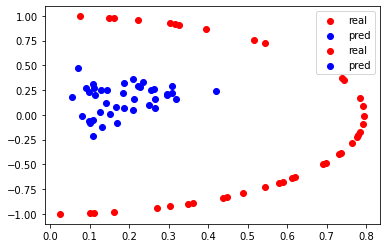

==================== EPOCH :  17 ====================
-------------------- TRAIN --------------------
train loss: 0.5412
-------------------- TEST --------------------
test loss: 0.6012


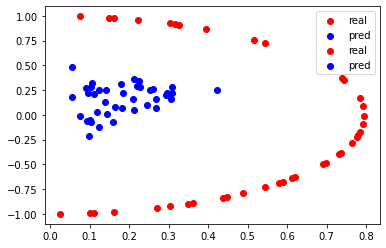

==================== EPOCH :  18 ====================
-------------------- TRAIN --------------------
train loss: 0.5626
-------------------- TEST --------------------
test loss: 0.5977


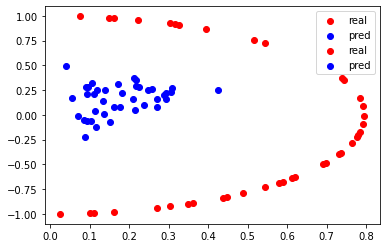

==================== EPOCH :  19 ====================
-------------------- TRAIN --------------------
train loss: 0.5572
-------------------- TEST --------------------
test loss: 0.5959


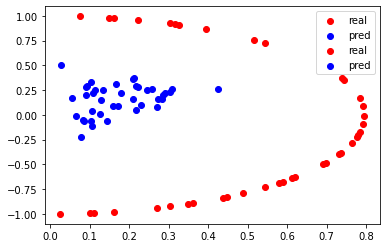

==================== EPOCH :  20 ====================
-------------------- TRAIN --------------------
train loss: 0.5329
-------------------- TEST --------------------
test loss: 0.5931


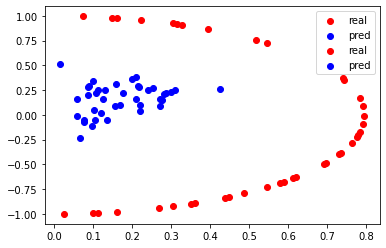

==================== EPOCH :  21 ====================
-------------------- TRAIN --------------------
train loss: 0.5304
-------------------- TEST --------------------
test loss: 0.5903


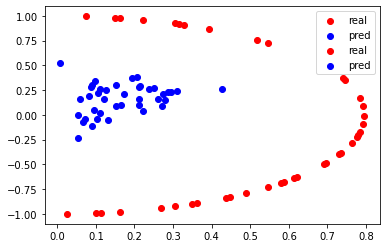

==================== EPOCH :  22 ====================
-------------------- TRAIN --------------------
train loss: 0.5250
-------------------- TEST --------------------
test loss: 0.5889


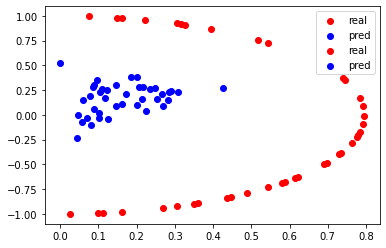

==================== EPOCH :  23 ====================
-------------------- TRAIN --------------------
train loss: 0.5140
-------------------- TEST --------------------
test loss: 0.5864


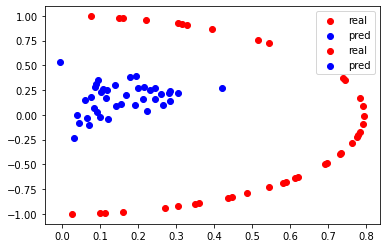

==================== EPOCH :  24 ====================
-------------------- TRAIN --------------------
train loss: 0.5644
-------------------- TEST --------------------
test loss: 0.5839


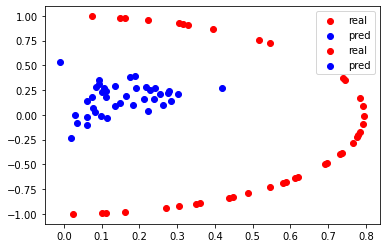

==================== EPOCH :  25 ====================
-------------------- TRAIN --------------------
train loss: 0.5637
-------------------- TEST --------------------
test loss: 0.5806


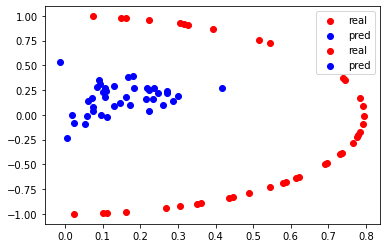

==================== EPOCH :  26 ====================
-------------------- TRAIN --------------------
train loss: 0.5641
-------------------- TEST --------------------
test loss: 0.5784


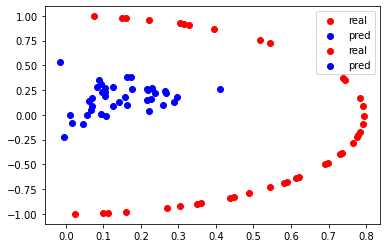

==================== EPOCH :  27 ====================
-------------------- TRAIN --------------------
train loss: 0.5184
-------------------- TEST --------------------
test loss: 0.5736


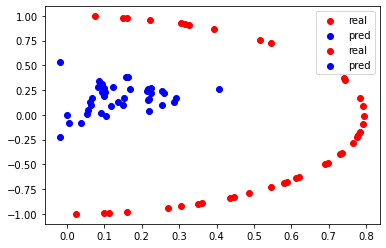

==================== EPOCH :  28 ====================
-------------------- TRAIN --------------------
train loss: 0.5636
-------------------- TEST --------------------
test loss: 0.5683


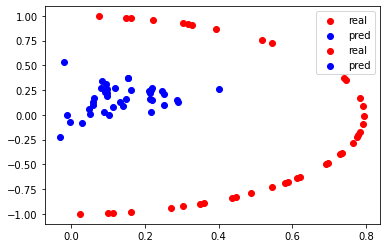

==================== EPOCH :  29 ====================
-------------------- TRAIN --------------------
train loss: 0.5255
-------------------- TEST --------------------
test loss: 0.5637


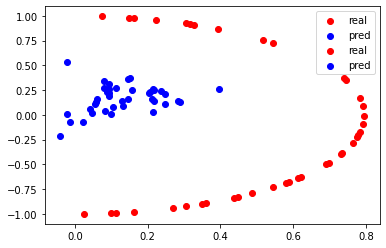

==================== EPOCH :  30 ====================
-------------------- TRAIN --------------------
train loss: 0.5470
-------------------- TEST --------------------
test loss: 0.5605


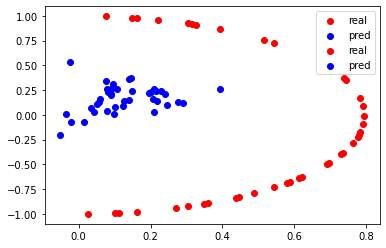

==================== EPOCH :  31 ====================
-------------------- TRAIN --------------------
train loss: 0.5698
-------------------- TEST --------------------
test loss: 0.5587


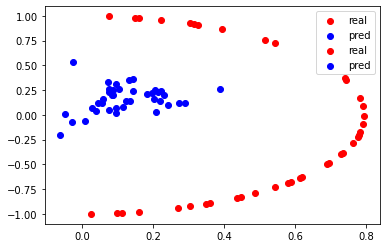

==================== EPOCH :  32 ====================
-------------------- TRAIN --------------------
train loss: 0.5441
-------------------- TEST --------------------
test loss: 0.5574


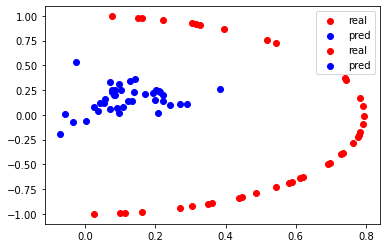

==================== EPOCH :  33 ====================
-------------------- TRAIN --------------------
train loss: 0.5651
-------------------- TEST --------------------
test loss: 0.5571


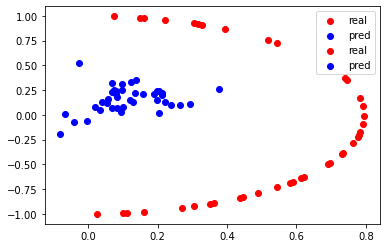

==================== EPOCH :  34 ====================
-------------------- TRAIN --------------------
train loss: 0.5499
-------------------- TEST --------------------
test loss: 0.5610


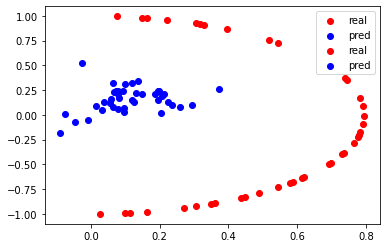

==================== EPOCH :  35 ====================
-------------------- TRAIN --------------------
train loss: 0.5366
-------------------- TEST --------------------
test loss: 0.5675


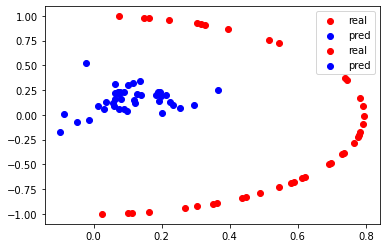

==================== EPOCH :  36 ====================
-------------------- TRAIN --------------------
train loss: 0.5957
-------------------- TEST --------------------
test loss: 0.5693


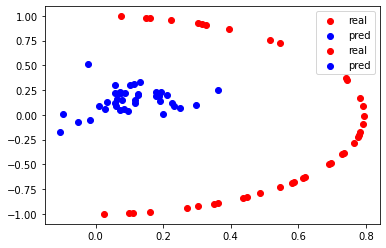

==================== EPOCH :  37 ====================
-------------------- TRAIN --------------------
train loss: 0.5895
-------------------- TEST --------------------
test loss: 0.5732


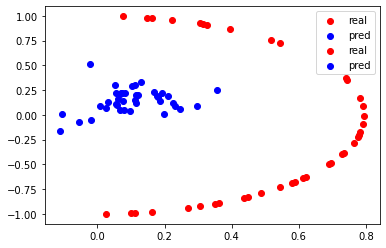

==================== EPOCH :  38 ====================
-------------------- TRAIN --------------------
train loss: 0.5485
-------------------- TEST --------------------
test loss: 0.5761


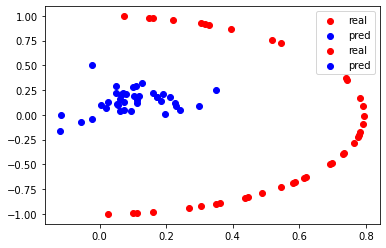

==================== EPOCH :  39 ====================
-------------------- TRAIN --------------------
train loss: 0.5826
-------------------- TEST --------------------
test loss: 0.5802


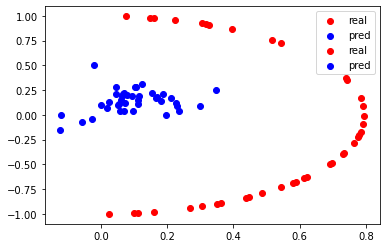

==================== EPOCH :  40 ====================
-------------------- TRAIN --------------------
train loss: 0.5368
-------------------- TEST --------------------
test loss: 0.5836


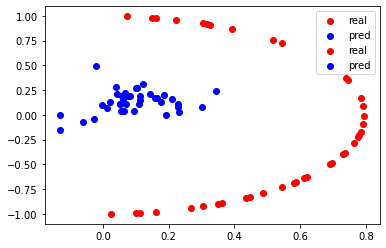

==================== EPOCH :  41 ====================
-------------------- TRAIN --------------------
train loss: 0.5327
-------------------- TEST --------------------
test loss: 0.5904


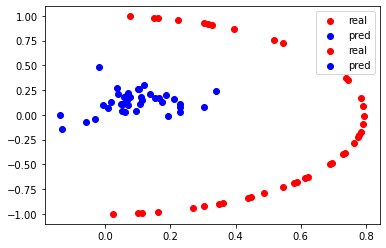

==================== EPOCH :  42 ====================
-------------------- TRAIN --------------------
train loss: 0.5161
-------------------- TEST --------------------
test loss: 0.5962


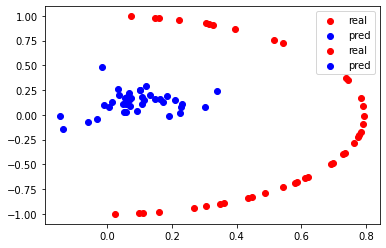

==================== EPOCH :  43 ====================
-------------------- TRAIN --------------------
train loss: 0.5240
-------------------- TEST --------------------
test loss: 0.6050


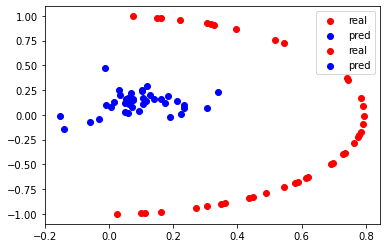

==================== EPOCH :  44 ====================
-------------------- TRAIN --------------------
train loss: 0.5579
-------------------- TEST --------------------
test loss: 0.6120


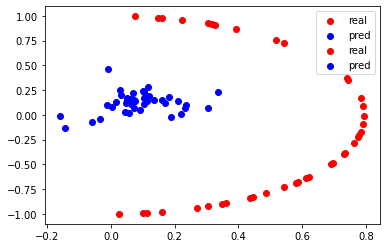

==================== EPOCH :  45 ====================
-------------------- TRAIN --------------------
train loss: 0.5243
-------------------- TEST --------------------
test loss: 0.6166


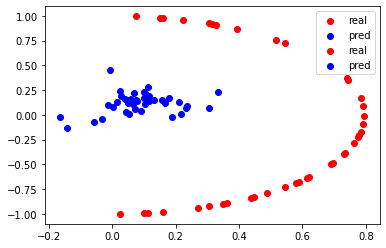

==================== EPOCH :  46 ====================
-------------------- TRAIN --------------------
train loss: 0.5364
-------------------- TEST --------------------
test loss: 0.6229


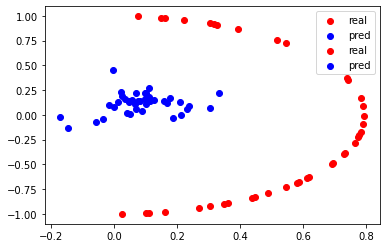

==================== EPOCH :  47 ====================
-------------------- TRAIN --------------------
train loss: 0.5235
-------------------- TEST --------------------
test loss: 0.6249


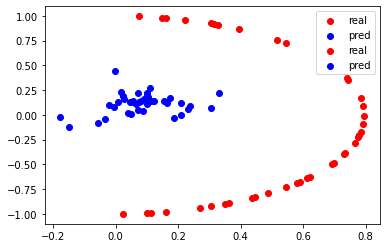

==================== EPOCH :  48 ====================
-------------------- TRAIN --------------------
train loss: 0.5508
-------------------- TEST --------------------
test loss: 0.6280


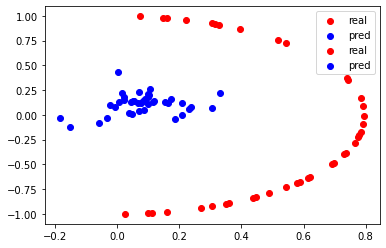

==================== EPOCH :  49 ====================
-------------------- TRAIN --------------------
train loss: 0.5022
-------------------- TEST --------------------
test loss: 0.6313


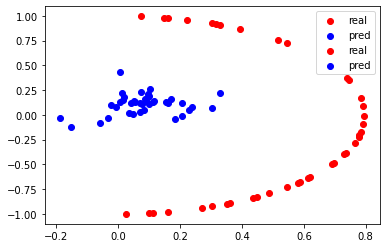

==================== EPOCH :  50 ====================
-------------------- TRAIN --------------------
train loss: 0.5427
-------------------- TEST --------------------
test loss: 0.6325


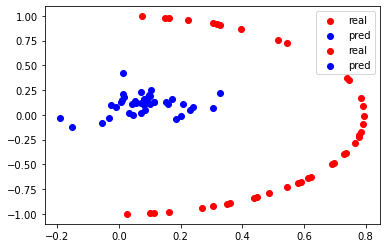

==================== EPOCH :  51 ====================
-------------------- TRAIN --------------------
train loss: 0.5803
-------------------- TEST --------------------
test loss: 0.6351


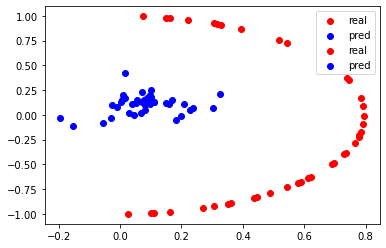

==================== EPOCH :  52 ====================
-------------------- TRAIN --------------------
train loss: 0.5260
-------------------- TEST --------------------
test loss: 0.6371


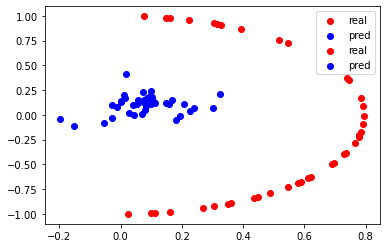

==================== EPOCH :  53 ====================
-------------------- TRAIN --------------------
train loss: 0.5053
-------------------- TEST --------------------
test loss: 0.6360


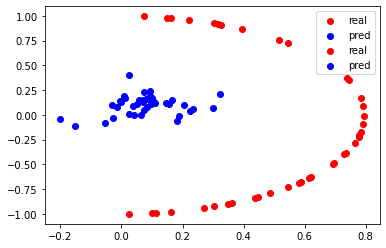

==================== EPOCH :  54 ====================
-------------------- TRAIN --------------------
train loss: 0.5429
-------------------- TEST --------------------
test loss: 0.6384


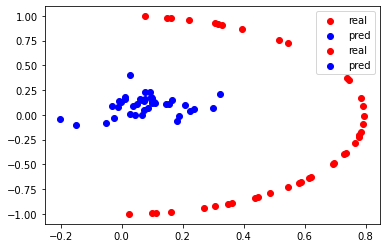

==================== EPOCH :  55 ====================
-------------------- TRAIN --------------------
train loss: 0.5615
-------------------- TEST --------------------
test loss: 0.6391


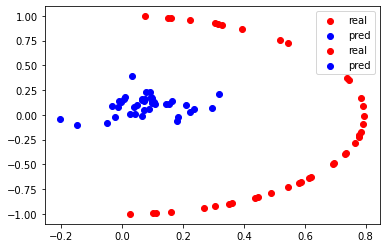

==================== EPOCH :  56 ====================
-------------------- TRAIN --------------------
train loss: 0.5457
-------------------- TEST --------------------
test loss: 0.6408


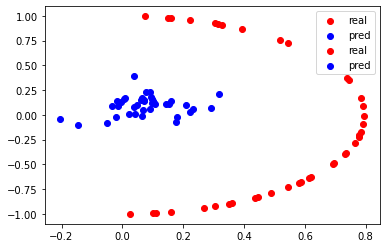

==================== EPOCH :  57 ====================
-------------------- TRAIN --------------------
train loss: 0.5253
-------------------- TEST --------------------
test loss: 0.6437


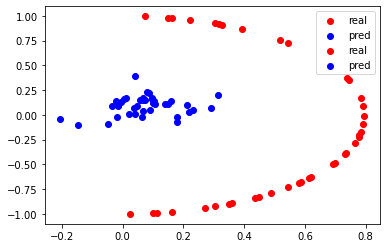

==================== EPOCH :  58 ====================
-------------------- TRAIN --------------------
train loss: 0.5321
-------------------- TEST --------------------
test loss: 0.6480


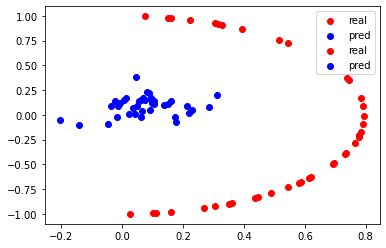

==================== EPOCH :  59 ====================
-------------------- TRAIN --------------------
train loss: 0.5325
-------------------- TEST --------------------
test loss: 0.6523


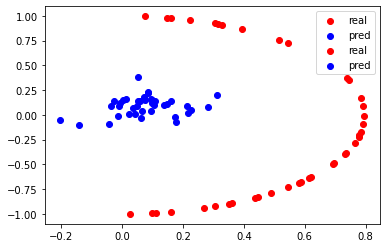

==================== EPOCH :  60 ====================
-------------------- TRAIN --------------------
train loss: 0.5255
-------------------- TEST --------------------
test loss: 0.6556


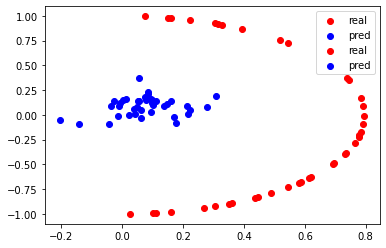

==================== EPOCH :  61 ====================
-------------------- TRAIN --------------------
train loss: 0.5585
-------------------- TEST --------------------
test loss: 0.6593


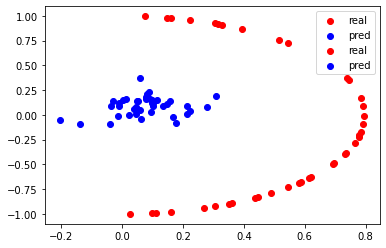

==================== EPOCH :  62 ====================
-------------------- TRAIN --------------------
train loss: 0.5548
-------------------- TEST --------------------
test loss: 0.6601


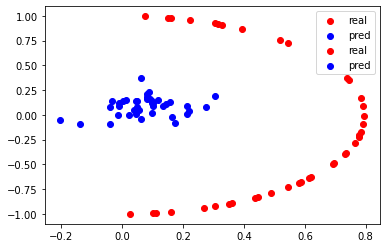

==================== EPOCH :  63 ====================
-------------------- TRAIN --------------------
train loss: 0.5206
-------------------- TEST --------------------
test loss: 0.6575


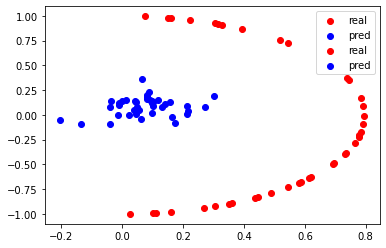

==================== EPOCH :  64 ====================
-------------------- TRAIN --------------------
train loss: 0.5498
-------------------- TEST --------------------
test loss: 0.6547


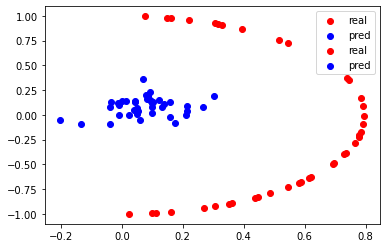

==================== EPOCH :  65 ====================
-------------------- TRAIN --------------------
train loss: 0.5266
-------------------- TEST --------------------
test loss: 0.6546


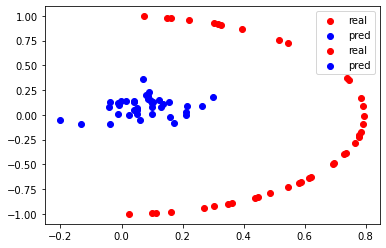

==================== EPOCH :  66 ====================
-------------------- TRAIN --------------------
train loss: 0.5579
-------------------- TEST --------------------
test loss: 0.6533


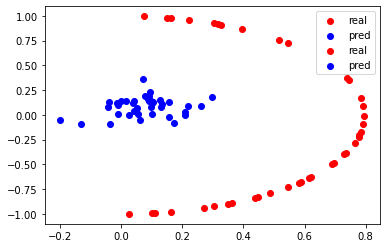

==================== EPOCH :  67 ====================
-------------------- TRAIN --------------------
train loss: 0.5437
-------------------- TEST --------------------
test loss: 0.6524


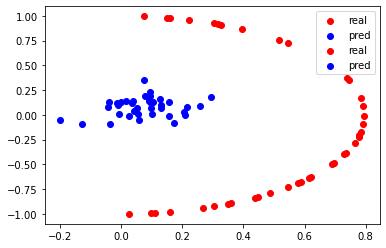

==================== EPOCH :  68 ====================
-------------------- TRAIN --------------------
train loss: 0.5015
-------------------- TEST --------------------
test loss: 0.6518


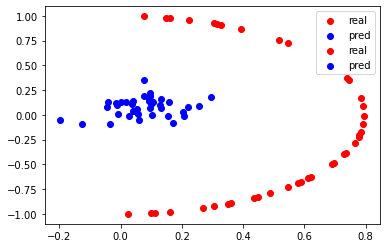

==================== EPOCH :  69 ====================
-------------------- TRAIN --------------------
train loss: 0.5371
-------------------- TEST --------------------
test loss: 0.6521


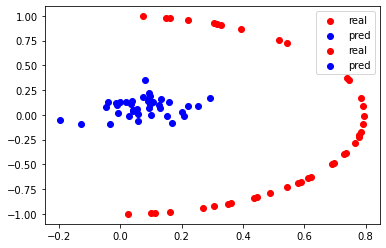

==================== EPOCH :  70 ====================
-------------------- TRAIN --------------------
train loss: 0.4905
-------------------- TEST --------------------
test loss: 0.6534


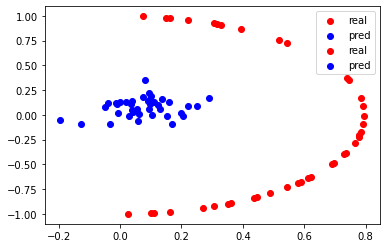

==================== EPOCH :  71 ====================
-------------------- TRAIN --------------------
train loss: 0.5340
-------------------- TEST --------------------
test loss: 0.6535


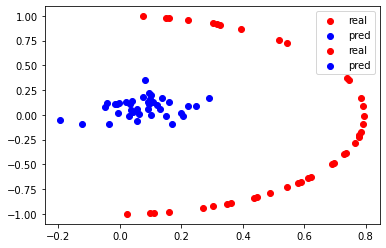

==================== EPOCH :  72 ====================
-------------------- TRAIN --------------------
train loss: 0.5202
-------------------- TEST --------------------
test loss: 0.6539


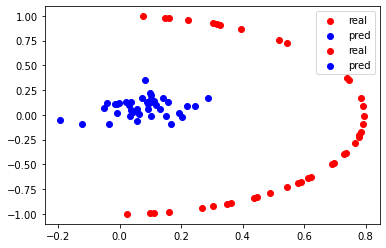

==================== EPOCH :  73 ====================
-------------------- TRAIN --------------------
train loss: 0.5283
-------------------- TEST --------------------
test loss: 0.6535


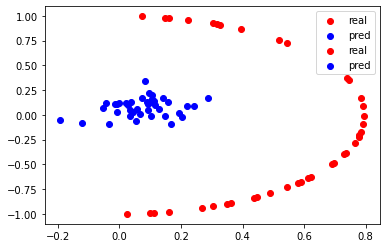

==================== EPOCH :  74 ====================
-------------------- TRAIN --------------------
train loss: 0.4985
-------------------- TEST --------------------
test loss: 0.6531


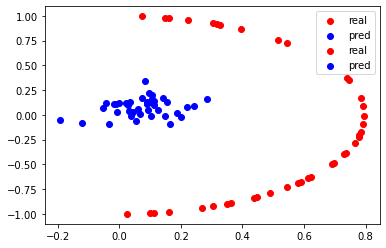

==================== EPOCH :  75 ====================
-------------------- TRAIN --------------------
train loss: 0.5581
-------------------- TEST --------------------
test loss: 0.6543


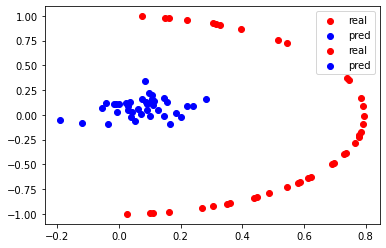

==================== EPOCH :  76 ====================
-------------------- TRAIN --------------------
train loss: 0.5381
-------------------- TEST --------------------
test loss: 0.6530


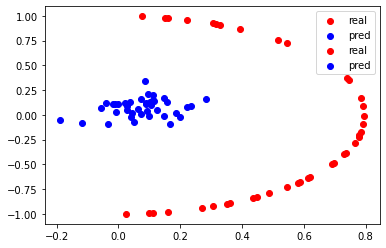

==================== EPOCH :  77 ====================
-------------------- TRAIN --------------------
train loss: 0.5177
-------------------- TEST --------------------
test loss: 0.6533


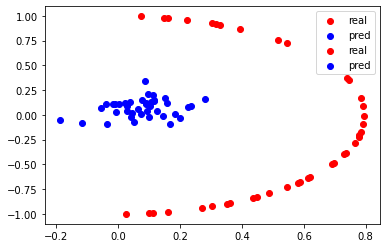

==================== EPOCH :  78 ====================
-------------------- TRAIN --------------------
train loss: 0.5151
-------------------- TEST --------------------
test loss: 0.6532


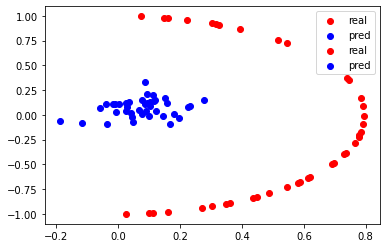

==================== EPOCH :  79 ====================
-------------------- TRAIN --------------------
train loss: 0.4975
-------------------- TEST --------------------
test loss: 0.6512


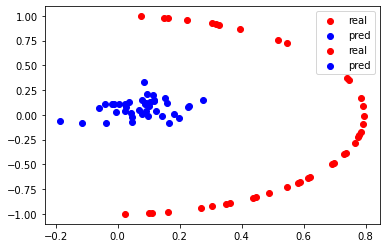

==================== EPOCH :  80 ====================
-------------------- TRAIN --------------------
train loss: 0.5477
-------------------- TEST --------------------
test loss: 0.6519


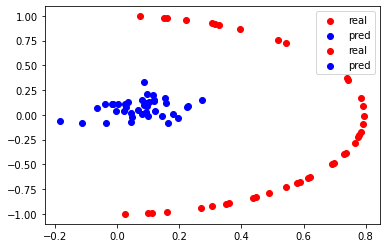

==================== EPOCH :  81 ====================
-------------------- TRAIN --------------------
train loss: 0.5474
-------------------- TEST --------------------
test loss: 0.6532


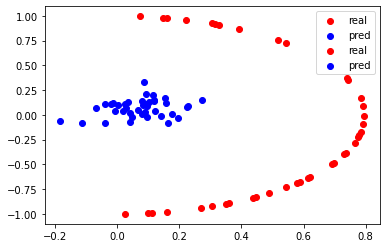

==================== EPOCH :  82 ====================
-------------------- TRAIN --------------------
train loss: 0.5405
-------------------- TEST --------------------
test loss: 0.6531


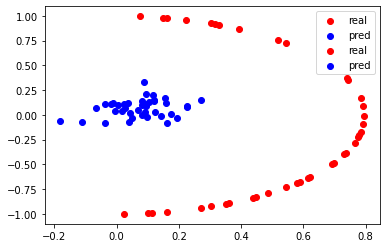

==================== EPOCH :  83 ====================
-------------------- TRAIN --------------------
train loss: 0.5603
-------------------- TEST --------------------
test loss: 0.6530


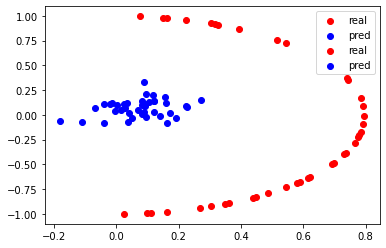

==================== EPOCH :  84 ====================
-------------------- TRAIN --------------------
train loss: 0.5424
-------------------- TEST --------------------
test loss: 0.6528


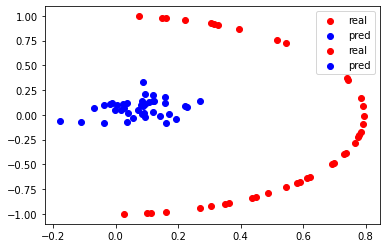

==================== EPOCH :  85 ====================
-------------------- TRAIN --------------------
train loss: 0.5064
-------------------- TEST --------------------
test loss: 0.6528


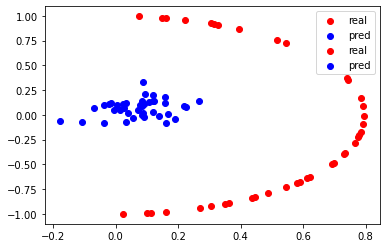

==================== EPOCH :  86 ====================
-------------------- TRAIN --------------------
train loss: 0.5454
-------------------- TEST --------------------
test loss: 0.6516


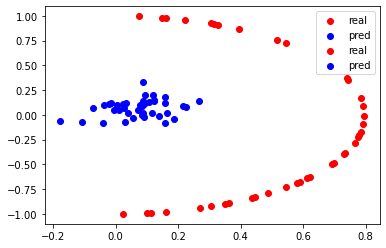

==================== EPOCH :  87 ====================
-------------------- TRAIN --------------------
train loss: 0.5271
-------------------- TEST --------------------
test loss: 0.6515


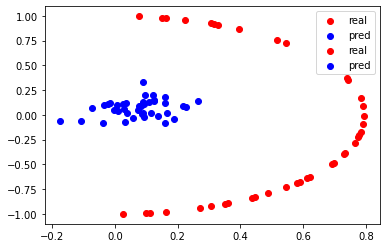

==================== EPOCH :  88 ====================
-------------------- TRAIN --------------------
train loss: 0.5748
-------------------- TEST --------------------
test loss: 0.6501


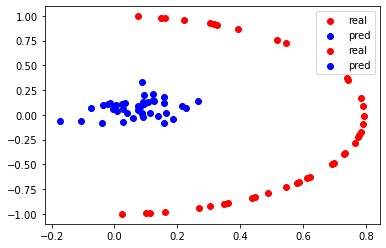

==================== EPOCH :  89 ====================
-------------------- TRAIN --------------------
train loss: 0.5424
-------------------- TEST --------------------
test loss: 0.6502


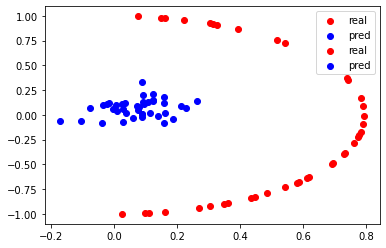

==================== EPOCH :  90 ====================
-------------------- TRAIN --------------------
train loss: 0.5355
-------------------- TEST --------------------
test loss: 0.6502


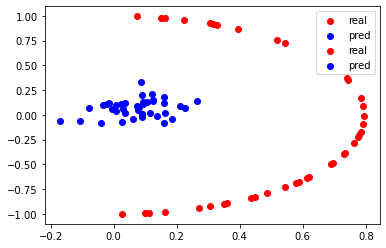

==================== EPOCH :  91 ====================
-------------------- TRAIN --------------------
train loss: 0.5688
-------------------- TEST --------------------
test loss: 0.6511


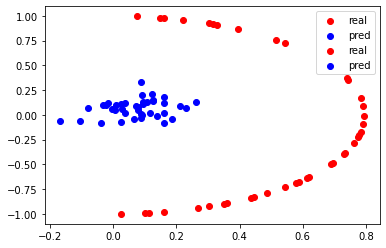

==================== EPOCH :  92 ====================
-------------------- TRAIN --------------------


In [ ]:
train_loss_list = []
test_loss_list = []
#num_epochs
for i in range(250):
    #logger.info("==================== EPOCH :  %d ===================="%i)
    print('='*20,'EPOCH : ', i,'='*20)
    print('-'*20,'TRAIN','-'*20)
    train(model, train_loader, opt)#, logger)
    print('-'*20,'TEST','-'*20)
    result = test(model, test_loader, opt, True)#, logger)
    scheduler.step()
    
#result

In [ ]:
test(model, test_loader, opt, True)

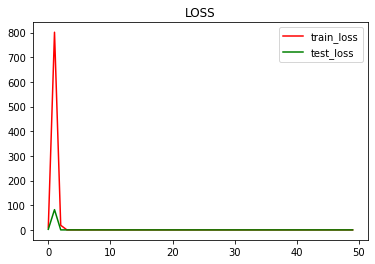

In [110]:
plt.plot(train_loss_list, 'r', label = 'train_loss')
plt.plot(test_loss_list, 'g', label = 'test_loss')
plt.title('LOSS')
plt.legend()
plt.show()

In [128]:
import numpy as np
import plotly.graph_objs as go
# digit = data[“train”][image_number][“label”]
#coordinate = np.load(‘/content/cube.obj.npy’)
coor_result = np.array(result)
print(coor_result, coor_result.shape)
layout = go.Layout(title = “Digit”)
plot_data = go.Scatter3d(x = coor_result[:,0], y = coor_result[:,1], z = coor_result[:,2],
                    mode = ‘markers’, marker = dict(size = 1))
fig = go.Figure(data = [plot_data], layout = layout)
fig.show()

SyntaxError: invalid character in identifier (<ipython-input-128-a2f4d1ca7f60>, line 7)

In [252]:
def plot2D(pred, real):
    plt.figure(figsize=(12,12))
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.scatter(pred[:,0], pred[:,1], s=20, c='b')
    plt.scatter(real[:,0], real[:,1], s=5, c='r')
#    print(pred[:,0]-real[:,0])
    plt.show()

In [256]:
plot2D(coor_result.to_numpy(), valid.to_numpy() )

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'